# Sujet : Influence du filtrage de l’EEG dans les protocoles de BCI

## Cas d’usage : Le SSVEP

### Données
MOABB/SSVEPExo dataset from E. Kalunga PhD in University of Versailles [1]_. (url). (classes = rest, 13Hz, 17Hz, 21Hz)
### Pipeline 
1. Filtrage dans les bandes de fréquences d’intérêt pour constituer un mega-signal de taille (Nch*Nf, Nt)
2. Epoching sur fenêtre glissante de 5s
3. Covariance spatiale (Nch*Nf, Nch*Nf)
4. Classif au choix (MDM, LR on tangent space..) 
MDM or Tangent Space Logistic Regression

### Question : 
 - Le choix du filtrage à l’étape (1) influence-t-il les scores de classification ? Je vois 3 variables : l’ordre, le type (iir vs. fir), la méthode d’application (lfilter vs. filtfilt)
 - Comment porter filtfilt en temps réel, quel taille d'époque par rapport  à l'ordre du filtre ? eg. Pyacq l’a fait dans OverlapFiltFilt. 

### Perspectives : 
- Si le but du MOABB est d’évaluer la performance de pipelines EEG pour une application BCI, alors le preprocessing (et en particulier le filtrage) devrait être portable en temps réel. MAJ du MOABB ?
- Étendre la question aux autres protocoles (eg. P300).

## Quick look at the dataset & paradigm 

In [1]:
import matplotlib.pyplot as plt
from moabb.datasets import SSVEPExo
from moabb.paradigms import SSVEP
import numpy as np
import pandas as pd 
from utils import get_avg_psd, epoch, compute_mega_raw, compute_mega_epochs
import pandas.util.testing as tm
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from timeflux_dsp.utils.filters import construct_iir_filter
from scipy.signal import filtfilt, lfilter
import seaborn as sns

paradigm = SSVEP(n_classes=4)
print(paradigm.__doc__)
dataset = SSVEPExo()


Choosing the first 4 classes from all possible events


Single bandpass filter SSVEP

    SSVEP paradigm with only one bandpass filter (default 7 to 45 Hz)
    Metric is 'roc-auc' if 2 classes and 'accuracy' if more

    Parameters
    ----------
    fmin: float (default 7)
        cutoff frequency (Hz) for the high pass filter

    fmax: float (default 45)
        cutoff frequency (Hz) for the low pass filter

    events: list of str | None (default None)
        List of stimulation frequencies. If None, use all stimulus
        found in the dataset.

    n_classes: int or None (default 2)
        Number of classes each dataset must have. All dataset classes if None

    tmin: float (default 0.0)
        Start time (in second) of the epoch, relative to the dataset specific
        task interval e.g. tmin = 1 would mean the epoch will start 1 second
        after the begining of the task as defined by the dataset.

    tmax: float | None, (default None)
        End time (in second) of the epoch, relative to the begining of the
        datas

In [2]:
data = dataset.get_data()
subjects = dataset.subject_list
N = len(subjects)
print(f'Found {N} subjects')
# check we have all classes we expected
_classes = set()
for subject in subjects:
    for session in data[subject].keys():
        for run in data[subject][session].keys():
            raw = data[subject][session][run]
            X, y, _ = paradigm.process_raw(raw, dataset)
            _classes = set(list(_classes) + list(set(y)))
print(f'Found class {_classes}')

Found 12 subjects
Found class {'21', '13', '17', 'rest'}


In [3]:
_pop_psd1_mean = []
_pop_psd2_mean = []
_pop_psd3_mean = []
_pop_psd4_mean = []
for subject in subjects:
    for session in data[subject].keys():
        for run in data[subject][session].keys():
            raw = data[subject][session][run]
            freq, psd1_mean, psd2_mean, psd3_mean, psd4_mean = get_avg_psd(raw)
            _pop_psd1_mean.append(psd1_mean)
            _pop_psd2_mean.append(psd2_mean)
            _pop_psd3_mean.append(psd3_mean)
            _pop_psd4_mean.append(psd4_mean)

np_pop_psd1_mean = np.stack(_pop_psd1_mean, axis=2).mean(axis=2)
np_pop_psd2_mean = np.stack(_pop_psd2_mean, axis=2).mean(axis=2)
np_pop_psd3_mean = np.stack(_pop_psd3_mean, axis=2).mean(axis=2)
np_pop_psd4_mean = np.stack(_pop_psd4_mean, axis=2).mean(axis=2)

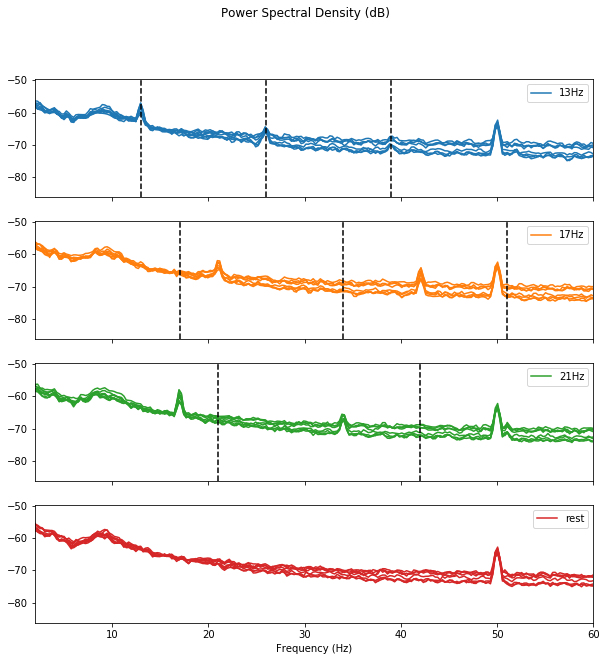

In [4]:
f, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True, sharey=True)
axs[0].plot(freq, np_pop_psd1_mean.T, color='C0')
axs[0].legend(['13Hz'])
axs[1].plot(freq, np_pop_psd2_mean.T, color='C1')
axs[1].legend(['17Hz'])
axs[2].plot(freq, np_pop_psd3_mean.T, color='C2')
axs[2].legend(['21Hz'])
axs[3].plot(freq, np_pop_psd4_mean.T, color='C3')
axs[3].legend(['rest'])

for k_plot, freq in enumerate([13, 17, 21, 0]):
    axs[k_plot].axvline(freq, color='k', linestyle='--')
    axs[k_plot].axvline(freq*2, color='k', linestyle='--')
    axs[k_plot].axvline(freq*3, color='k', linestyle='--')
    
plt.suptitle('Power Spectral Density (dB)')
axs[-1].set_xlim((2, 60))
axs[-1].set_xlabel('Frequency (Hz)'); 

## Filtfilt vs. LFilter on SSVEP scores 

In [5]:
from collections import OrderedDict

from pyriemann.classification import MDM
from pyriemann.estimation import Covariances
from pyriemann.spatialfilters import CSP
from pyriemann.tangentspace import TangentSpace
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,StratifiedShuffleSplit,  TimeSeriesSplit
from sklearn.pipeline import make_pipeline

clfs = OrderedDict()

#clfs['CSP + RegLDA'] = make_pipeline(Covariances(), CSP(4), LDA(shrinkage='auto', solver='eigen'))
clfs['Cov + TS'] = make_pipeline(Covariances(), TangentSpace(), LogisticRegression())
clfs['Cov + MDM'] = make_pipeline(Covariances(), MDM())
#clfs['CSP + Cov + TS'] = make_pipeline(Covariances(), CSP(4, log=False), TangentSpace(), LogisticRegression())

# define cross validation
#cv = TimeSeriesSplit(n_splits=2, max_train_size=15)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.75,
                            random_state=42)
for train_index, test_index in cv.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)

def compare_pipelines(X, y):
    # run cross validation for each pipeline
    auc = []
    methods = []
    for m in clfs:
        try:
            avg_res = []
            for label in set(y):
                res = cross_val_score(clfs['Cov + TS'], X, y==label, scoring='roc_auc',
                                              cv=cv, n_jobs=-1)
                avg_res.append(res)
            avg_res = np.mean(np.vstack(avg_res), axis=0)
            auc.extend(res)
            methods.extend([m] * len(res))
        except Exception as e:
            print(e)

    results = pd.DataFrame(data=auc, columns=['AUC'])
    results['Method'] = methods
    return results


TRAIN: [23  2 17 14 26  8 30  4] TEST: [ 7 20  9  5 22  6 25  1 15 19 31  0 24 13  3 29 16 10 28 27 12 18 21 11]
TRAIN: [13 20 31 19  2  0  4 30] TEST: [10 25 16 24  8 23  1 28 11  9 14 29  6 22  5 12 17  3 27 26 15 18 21  7]
TRAIN: [ 4 20  7 22 11 31 15 16] TEST: [ 6  2 23 30 26 13 25 14  5  8 17 27 21 28 18  0 12 10 19 29 24  1  9  3]
TRAIN: [21  7 12  9 20 10 24  5] TEST: [ 1 13 14  4 15 23 25 22  2  6 18 30 26 16  8 31 19 28 11 27 29  0  3 17]
TRAIN: [ 5 31 13 12  3  6  4  1] TEST: [24 23  8 22 29 10 15  9 14  0 28 26 21 16 17 18 30 25 11 20  7  2 19 27]


In [6]:
params = dict(frequencies = ([12, 14], [16, 18], [20, 22]), tmin=1, tmax=5)

filt_methods = ['lfilter', 'filtfilt']
orders = [1, 3, 6]

pop_results = []
for subject in subjects: #subjects
    for session in data[subject].keys():
        for run in data[subject][session].keys():
            for filt_method in filt_methods:
                for order in orders: 
                    raw = data[subject][session][run]
                    mega_raw, X, y = compute_mega_epochs(raw, filt_method=filt_method, order=order, **params)
                    results = compare_pipelines(X, y)
                    results['subject'] = subject
                    results['session'] = session
                    results['run'] = run
                    results['filtering'] = filt_method
                    results['order'] = 'order: ' + str(order)
                    pop_results.append(results)
df_pop_results = pd.concat(pop_results)


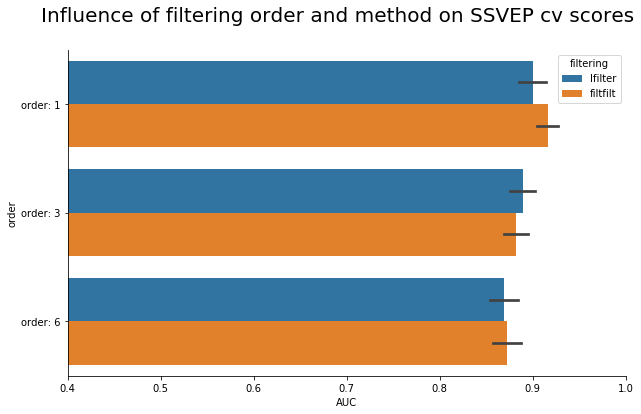

In [7]:
fig = plt.figure(figsize=[10,6])
sns.barplot(data=df_pop_results, x='AUC', y='order', hue='filtering')
plt.xlim(0.4, 1)
sns.despine()
plt.suptitle('Influence of filtering order and method on SSVEP cv scores', fontsize=20); 


## FiltFilt over an epoch 
Generate sinus waves and visualize the influence of epoch window on the filtfilt output. 

In [8]:
rate = 256
n = int(rate * 30)  # 30 seconds of data
m = 3

f_carrier = 13
a_carrier = 1.0

f_noise = 17
a_noise = 0.2

tm.K = m  # tm will generate 7 columns
original = tm.makeTimeDataFrame(n, freq='L').rename(
    columns={
        'A': 'noise',
        'B': 'carrier',
        'C': 'signal',
    }
)
original.index = original.index[0] + pd.to_timedelta(np.arange(n) / rate, unit='s')
t = (original.index - original.index[0]) / np.timedelta64(1, 's')
original['noise'] = a_noise * np.sin(2 * np.pi * f_noise * t)
original['carrier'] = a_carrier * np.sin(2 * np.pi * f_carrier * t)
original['signal'] = original.carrier + original.noise

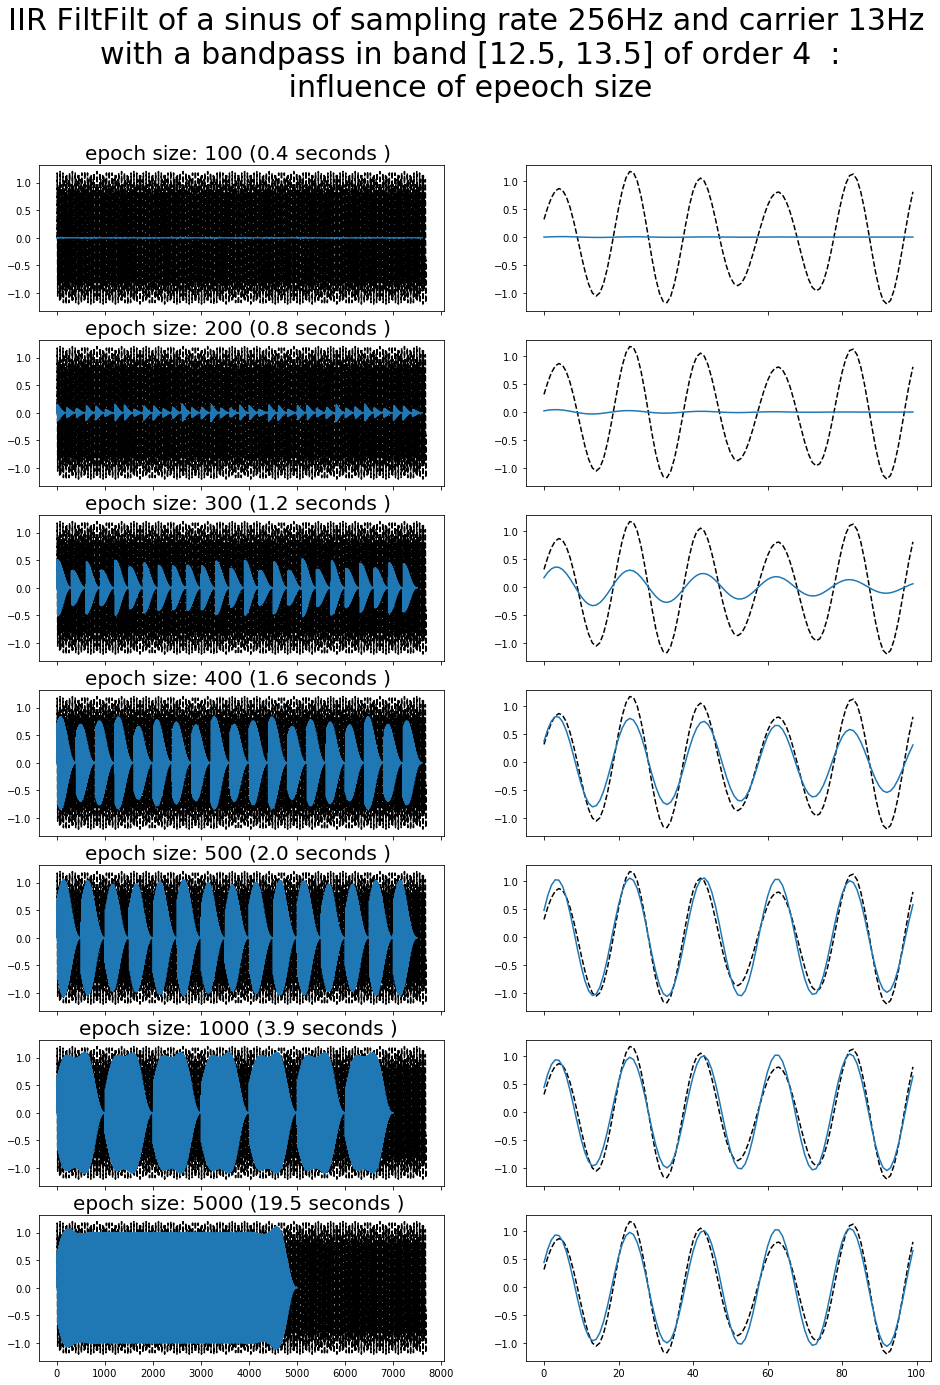

In [9]:
frequencies = [12.5, 13.5]
order = 4

ba, _ = construct_iir_filter(rate, frequencies, 'bandpass', order=order, output='ba')

filt_method = filtfilt
carrier_signal = original['signal'].values

epoch_size = 200 #len(original)
epoch_sizes = [100, 200, 300, 400, 500, 1000, 5000]
f, ax = plt.subplots(7, 2, figsize=(16, 22), sharex='col')
for k, epoch_size in enumerate(epoch_sizes):
    epoched = epoch(carrier_signal, epoch_size, epoch_size)
    epoch_filtered = np.apply_along_axis(lambda chunk: filt_method(*ba, chunk), axis=1, arr=epoched).reshape(-1, 1)[:, 0]
    ax[k, 0].plot(carrier_signal, color='k', linestyle='--')
    ax[k, 0].plot(epoch_filtered)
    ax[k, 1].plot(carrier_signal[100:200], color='k', linestyle='--')
    ax[k, 1].plot(epoch_filtered[100:200])
    ax[k, 0].set_title(f'epoch size: {epoch_size} ({round(epoch_size/rate, 1)} seconds ) ', fontsize=20)
plt.suptitle(f'IIR FiltFilt of a sinus of sampling rate {rate}Hz and carrier {f_carrier}Hz \n' +
             f'with a bandpass in band {frequencies} of order {order}  :\n influence of epeoch size ', fontsize=30); 